# Libraries

In [160]:
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Parameters

In [161]:
TAX_RATE = 0.275
METHOD = "ACB" # ACB, FIFO, LIFO, HIFO
VERBOSE = True

# Functions

In [162]:
def tax_calculator_ACB(selling_units, selling_price, average_purchase_price):
    """
    Calculate the profit and taxes based on selling units, selling price,
    and average purchase price.

    The function computes the total purchase value of the units sold at
    their average purchase price, calculates the profit by subtracting
    the purchase value from the selling value, and applies taxes only
    if the profit is positive.

    Args:
        selling_units (int or float): Number of units sold.
        selling_price (float): Selling price per unit.
        average_purchase_price (float): Average purchase price per unit.

    Returns:
        tuple: A tuple containing:
            - capital_gain (float): The calculated capital gain from the sale.
            - taxes (float): The calculated taxes based on profit and a
              predefined TAX_RATE. If no profit, taxes will be 0.
    """
    # Purchase value that the selling units would have if bought at the same price
    average_purchase_value = selling_units * average_purchase_price

    # Profit: current selling value - average purchase value
    sold_value = selling_units * selling_price
    capital_gain = sold_value - average_purchase_value

    # Calculate taxes only if profit is positive
    taxes = 0
    if capital_gain > 0:
        taxes = capital_gain * TAX_RATE

    return capital_gain, taxes

def calculate_units_to_remove_from_purchase_order(purchase_order_units, units_to_sell_avg, number_of_purchase_orders, counter_order):
  """
  Calculate the number of units to sell and adjust the average units to sell
  per purchase order based on the difference between available purchase order
  units and the average units to sell.

  If the available units in the current purchase order are less than the
  average units to sell, the average is adjusted for the remaining purchase
  orders, and all units from the current order are sold. Otherwise, the
  average units are sold.

  Args:
      purchase_order_units (int or float): The number of units in the current purchase order.
      units_to_sell_avg (float): The average number of units to sell from each purchase order.
      number_of_purchase_orders (int): The total number of purchase orders.
      counter_order (int): The current purchase order index being processed.

  Returns:
      tuple: A tuple containing:
          - units_to_sell (float): The actual number of units to sell from the current order.
          - units_to_sell_avg (float): The updated average units to sell for future orders.
  """

  # Calculate the difference between purchase order units and average units to sell
  units_diff = purchase_order_units - units_to_sell_avg

  if units_diff <0:
    # If not enough units are available, adjust the average units to sell
    n = number_of_purchase_orders  - counter_order # Remaining purchase orders
    units_to_sell_avg += abs(units_diff) / n # Adjust the average
    units_to_sell = purchase_order_units # Sell all available units
  else:
    # If enough units are available, sell the average amount
    units_to_sell = units_to_sell_avg

  return units_to_sell, units_to_sell_avg

def upldate_balance(df_balance, df_balance_asset, total_units_to_sell, asset_to_sell):
    """
    Update the balance of units based on the total units to sell and the temporary balance
    of purchase orders. This function adjusts the units in the original balance DataFrame
    and returns the updated balance along with the total number of units sold.

    Args:
        df_balance (DataFrame): The original balance DataFrame containing current unit counts.
        df_balance_temp (DataFrame): The temporary DataFrame of purchase orders to process.
        total_units_to_sell (int or float): The total number of units to sell from the balance.

    Returns:
        tuple: A tuple containing:
            - df_balance (DataFrame): The updated balance DataFrame after processing.
            - tot_units_sold (int or float): The total number of units sold during the update.
    """

    # Define parameters for balance update
    counter_order = 1  # Count how many purchase orders have been processed
    tot_units_sold = 0  # Keep track of how many units have been removed from balance
    number_of_purchase_orders = df_balance_asset[df_balance_asset['Asset']==asset_to_sell].shape[0]  # Number of purchase orders
    units_to_sell_avg = total_units_to_sell / number_of_purchase_orders  # Average units to remove from each order

    # Update balance
    for j, row_b in df_balance_asset[df_balance_asset['Asset']==asset_to_sell].iterrows():
        # Remove units from purchase orders
        units_to_sell, units_to_sell_avg = calculate_units_to_remove_from_purchase_order(
            purchase_order_units=row_b['Units'],
            units_to_sell_avg=units_to_sell_avg,
            number_of_purchase_orders=number_of_purchase_orders,
            counter_order=counter_order
        )

        # Subtract the units to sell from the balance DataFrame
        df_balance.loc[j, 'Units'] -= units_to_sell

        # Update the counter for the next order
        counter_order += 1

        # Update the total number of units sold
        tot_units_sold += units_to_sell

    # Remove from balance orders which no longer have units
    df_balance = df_balance[df_balance['Units'] > 0].reset_index(drop=True)

    return df_balance, tot_units_sold

def tax_calculator_XYFO(selling_units, selling_price, df_balance, df_balance_temp):
  """
  Calculate the capital gain and taxes based on selling units, updating the balance of units.

  The function processes the units sold from the current balance, updates the balance DataFrame,
  and calculates the capital gain and taxes. It iterates through the purchase orders, selling
  units from each until the required number of units are sold or no more units are available.

  Args:
      selling_units (int or float): Number of units to sell.
      df_balance (DataFrame): The original balance DataFrame containing current unit counts.
      df_balance_temp (DataFrame): Temporary DataFrame with purchase order details.

  Returns:
      tuple: A tuple containing:
          - capital_gain (float): The calculated capital gain from the sale.
          - taxes (float): The calculated taxes based on capital gain and a predefined TAX_RATE.
          - df_balance (DataFrame): The updated balance DataFrame after processing.
          - tot_units_sold (int or float): The total number of units sold.
  """

  # Initialize variables for tracking progress
  tot_units_sold = 0 # Track how many units have been removed from the balance
  total_units_to_sell = selling_units # Total units to sell
  units_to_sell = total_units_to_sell  # Units left to sell
  capital_gain = 0 # Initliaze capital gains
  taxes = 0 # Initliaze taxes
  flag = False # Flag to stop the loop when no more units need to be sold

  # Iterate through the temporary balance (purchase orders)
  for j, row_b in df_balance_temp.iterrows():
    # Check if the units in the current purchase order are less than or equal to units to sell
    if row_b['Units'] <= units_to_sell:
      # Sell all units from this purchase order
      df_balance.loc[j, "Units"] = 0 # Set units in the balance to zero
      units_sold = row_b["Units"]    # Number of units sold from this order
      units_to_sell -= units_sold    # Subtract the sold units from units_to_sell
      tot_units_sold +=units_sold    # Add to total units sold
    else:
      # Sell only the required number of units and stop further processing
      units_sold = units_to_sell
      df_balance.loc[j, "Units"] = row_b["Units"] - units_to_sell # Update remaining units
      tot_units_sold += units_sold
      flag = True # Set flag to exit the loop since all required units are sold

    # Calculate capital gain for the units sold from this purchase order
    cg = units_sold*(selling_price - row_b['Price'])
    capital_gain += cg

    if VERBOSE:
      print(f"Purchased {row_b['Units']} units at {row_b['Price']} and sold them at {selling_price}. Capital gain {round(cg,2)}")

    # Exit the loop once all units are sold
    if flag:
      break

  # Calculate taxes if there's a positive capital gain
  if capital_gain > 0:
    taxes = capital_gain * TAX_RATE

  return capital_gain, taxes, df_balance, tot_units_sold

def take_balance_snapshot(df_balance_evolution, df_balance, date):
    """
    Capture a snapshot of the current balance and add it to the balance evolution DataFrame.

    This function takes the current state of the balance (including asset names, units, and prices),
    records the specified date, and appends this snapshot to an existing DataFrame that tracks
    the evolution of balances over time.

    Args:
        df_balance_evolution (DataFrame): The existing DataFrame tracking historical balance snapshots.
        df_balance (DataFrame): The current balance DataFrame containing asset details.
        date (str or datetime): The date to assign to the snapshot.

    Returns:
        DataFrame: The updated DataFrame (`df_balance_evolution`) with the new snapshot added.
    """
    
    # Create a snapshot of the current balance with selected columns
    df_balance_snapshot = df_balance[['Asset', 'Units', 'Price']].copy()
    
    # Add the date to the snapshot
    df_balance_snapshot.loc[:, 'Date'] = date
    
    # Append the snapshot to the historical balance evolution DataFrame
    df_balance_evolution = pd.concat([df_balance_evolution, df_balance_snapshot])
    
    return df_balance_evolution

# Load data

## Transactions

In [163]:
df_transactions = pd.read_csv('transactions_01.csv', sep=";")
df_transactions['Date'] = pd.to_datetime(df_transactions['Date'], format='%d/%m/%Y')
df_transactions

,Date,Type,Units,Asset,Price,Currency
0,2024-01-01,Purchase,1.0,BTC,50000.0,EUR
1,2024-09-15,Swap,1.0,BTC,NaN,NaN
2,2024-09-15,Swap,5.0,ETH,NaN,NaN
3,2024-11-15,Sell,2.5,ETH,16000.0,EUR


## Purchase

In [164]:
df_purchase = df_transactions[df_transactions["Type"]=='Purchase'].reset_index(drop=True)
df_purchase

,Date,Type,Units,Asset,Price,Currency
0,2024-01-01,Purchase,1.0,BTC,50000.0,EUR


# Sell

In [165]:
df_sales = df_transactions[df_transactions["Type"]=='Sell'].reset_index(drop=True)
df_sales['Value'] = df_sales['Units']*df_sales['Price']
df_sales

,Date,Type,Units,Asset,Price,Currency,Value
0,2024-11-15,Sell,2.5,ETH,16000.0,EUR,40000.0


# Calculate Taxes

In [176]:
# step 1 Loop through all transactions which are not purchase
# Step 2 Check if current transaction is swap or sell
# step 2 Select transactions from balance (copy of original purchase) less then date from step 1

# Initiate
df_balance = df_purchase.copy()
sales_infos = []

# Initate balance evolution
first_transaction_date = df_transactions[df_transactions['Type']!='Purchase'].iloc[0]['Date']
df_balance_snapshot = df_balance[df_balance['Date']<first_transaction_date][['Asset','Units','Price']].copy()
df_balance_snapshot.loc[:,'Date'] = first_transaction_date
df_balance_evolution = df_balance_snapshot

# Select transactions which are not a Purchase
change_events = df_transactions[df_transactions['Type']!="Purchase"][['Date','Type']].drop_duplicates()

if VERBOSE:
    print("######################################################################")
    print(f"\t\t\t\t{METHOD}")
    print("######################################################################\n")
    print("Original Balance:")
    print(df_balance[df_balance['Date']<first_transaction_date])
    print('\n----------------------------------------------------------------------\n')
    
    

# Loop through all events which modify the balance
for i, change in  change_events.iterrows():

    # Update balance
    if change['Type'] == "Swap":

        # Select swap
        swap = df_transactions[(df_transactions['Type']=="Swap") & (df_transactions['Date']==change['Date'])]

        # Split between asset in and out
        asset_out = swap.iloc[[0]]
        asset_in  = swap.iloc[[1]]

        # Select from balance all transactions for swapped asset up to change event
        df_balance_asset = df_balance[(df_balance['Asset']==asset_out['Asset'].iloc[0]) & (df_balance['Date']<change['Date'])]

        # Calculate average purchase price of new asset
        average_purchase_price = (df_balance_asset['Units']*df_balance_asset['Price']).sum()/asset_in['Units'].sum()

        # Update balance swapped asset (out)
        df_balance_asset_updated, _ = upldate_balance(df_balance_asset,
                                                      df_balance_asset,
                                                      asset_out['Units'].iloc[0],
                                                      asset_out['Asset'].iloc[0])
        # Include swaped asset (in)
        asset_in.loc[:,'Price'] = average_purchase_price
        asset_in.loc[:,'Currency'] = "EUR" # This could be further improved for other currencies
        df_balance_asset_updated = pd.concat([df_balance_asset_updated, asset_in]).reset_index(drop=True)

        # Update all balance up to swap event
        df_balance_other_previous_assets = df_balance[(df_balance['Asset']!=asset_out['Asset'].iloc[0]) & (df_balance['Date']<change['Date'])]
        df_balance = pd.concat([df_balance_asset_updated, df_balance_other_previous_assets, df_balance[(df_balance['Date']>change['Date'])]]).sort_values(by='Date').reset_index(drop=True)

        if VERBOSE:
            print(f"Swapped {asset_out['Units'].iloc[0]} units of {asset_out['Asset'].iloc[0]} for {asset_in['Units'].iloc[0]} units of {asset_in['Asset'].iloc[0]}.")
            print(f"Calculated average Purchase Price for  {asset_in['Units'].iloc[0]} {asset_in['Asset'].iloc[0]}: {round(average_purchase_price,2)}.\n")
            
    elif change['Type'] == "Sell":
        
        # Select sell
        sell = df_transactions[(df_transactions['Type']=="Sell") & (df_transactions['Date']==change['Date'])]

        # Select from balance all transactions for sold asset up to change event
        df_balance_asset = df_balance[(df_balance['Asset']==sell['Asset'].iloc[0]) & (df_balance['Date']<change['Date'])]

        # Check if units can be sold:
        if sell['Units'].iloc[0] <= df_balance_asset['Units'].sum():

            if METHOD == "ACB":

                # Sort filtered balance by value
                df_balance_asset = df_balance_asset.sort_values("Units")   

                # Calculate average purchasing price
                average_purchase_price = (df_balance_asset['Units']*df_balance_asset['Price']).sum()/df_balance_asset['Units'].sum()

                # Calculate capital gain and taxes
                capital_gain, taxes = tax_calculator_ACB(selling_units=sell['Units'].iloc[0],
                                                         selling_price=sell['Price'].iloc[0],
                                                         average_purchase_price=average_purchase_price)

                

                # Update balance
                df_balance_asset_updated, tot_units_sold = upldate_balance(df_balance_asset,
                                                                           df_balance_asset,
                                                                           sell['Units'].iloc[0],
                                                                           sell['Asset'].iloc[0])
                
                if VERBOSE:
                    print(f"Average Purchase Price: {round(average_purchase_price,2)}")
                    print(f"Sold {sell['Units'].iloc[0]} units for a value of {sell['Price'].iloc[0]*sell['Units'].iloc[0]}. The {sell['Units'].iloc[0]} units where purchased at averaged price of {round(average_purchase_price,2)}, which means their average value is {round(sell['Units'].iloc[0]*average_purchase_price, 2)}")
                    print(f"Capital Gain: {round(capital_gain,2)} ({round(sell['Price'].iloc[0]*sell['Units'].iloc[0], 2)} - {round(sell['Units'].iloc[0]*average_purchase_price,2)})")
                    print(f"Taxes: {taxes}\n")
            
            elif METHOD in ["FIFO", "LIFO", "HIFO"]:
                
                # Select right model
                if METHOD == "FIFO":
                    # Sort filtered balance by date
                    df_balance_asset = df_balance_asset.sort_values("Date")
                elif METHOD == "LIFO":
                    # Sort filtered balance by date in descending order
                    df_balance_asset = df_balance_asset.sort_values("Date", ascending=False)
                elif METHOD == "HIFO":
                    # Sort filtered balance by value in descending order
                    df_balance_asset = df_balance_asset.sort_values("Price", ascending=False)

                # Calculate capital gain, taxes and update balance
                capital_gain, taxes, df_balance_asset_updated, tot_units_sold = tax_calculator_XYFO(selling_units=sell['Units'].iloc[0],
                                                                                                    selling_price=sell['Price'].iloc[0],
                                                                                                    df_balance=df_balance_asset,
                                                                                                    df_balance_temp=df_balance_asset)

                # Remove from balance orders which no longer have units
                df_balance_asset_updated = df_balance_asset_updated[df_balance_asset_updated['Units'] > 0].reset_index(drop=True)
   
                if VERBOSE:
                  print(f"\nSold {sell['Units'].iloc[0]} units for a value of {round(sell['Units'].iloc[0]*sell['Price'].iloc[0],2)}.")
                  print(f"Capital Gain: {round(capital_gain,2)}")
                  print(f"Taxes: {taxes}\n")

            else:
        
              raise Exception(f"Method not implemented: {METHOD}")

            # Store profit/taxes infos in sales dataframe
            sales_infos.append({'Capital Gain':capital_gain,
                                'Taxes':taxes,
                                'Net Profit':capital_gain - taxes,
                                'Average Purchase Price':round(average_purchase_price,2)})

            # Update all balance up to sell event
            df_balance_other_previous_assets = df_balance[(df_balance['Asset']!=sell['Asset'].iloc[0]) & (df_balance['Date']<change['Date'])]
            df_balance = pd.concat([df_balance_asset_updated, df_balance_other_previous_assets, df_balance[(df_balance['Date']>change['Date'])]]).sort_values(by='Date').reset_index(drop=True)

        else:
            raise Exception(f"Too many units to be sold! {row_s['Units']} > {df_balance_temp['Units'].sum()}")
        
    # Collect balances snapshots to track its evolution
    df_balance_evolution = take_balance_snapshot(df_balance_evolution, df_balance[df_balance['Date']<=change['Date']], change['Date'].date())
   
    if VERBOSE:
      print("Updated Balance:")
      print(df_balance[df_balance['Date']<=change['Date']])
      print('\n----------------------------------------------------------------------\n')

# Add sales additional infos
df_sales_tax = df_sales.join(pd.DataFrame(sales_infos))

df_sales_tax

######################################################################
				ACB
######################################################################

Original Balance:
        Date      Type  Units Asset    Price Currency
0 2024-01-01  Purchase    1.0   BTC  50000.0      EUR

----------------------------------------------------------------------

Swapped 1.0 units of BTC for 5.0 units of ETH.
Calculated average Purchase Price for  5.0 ETH: 10000.0.

Updated Balance:
        Date  Type  Units Asset    Price Currency
0 2024-09-15  Swap    5.0   ETH  10000.0      EUR

----------------------------------------------------------------------

Average Purchase Price: 10000.0
Sold 2.5 units for a value of 40000.0. The 2.5 units where purchased at averaged price of 10000.0, which means their average value is 25000.0
Capital Gain: 15000.0 (40000.0 - 25000.0)
Taxes: 4125.0

Updated Balance:
        Date  Type  Units Asset    Price Currency
0 2024-09-15  Swap    2.5   ETH  10000.0      EUR

------

,Date,Type,Units,Asset,Price,Currency,Value,Capital Gain,Taxes,Net Profit,Average Purchase Price
0,2024-11-15,Sell,2.5,ETH,16000.0,EUR,40000.0,15000.0,4125.0,10875.0,10000.0


In [177]:
df_balance

,Date,Type,Units,Asset,Price,Currency
0,2024-09-15,Swap,2.5,ETH,10000.0,EUR


# Plot

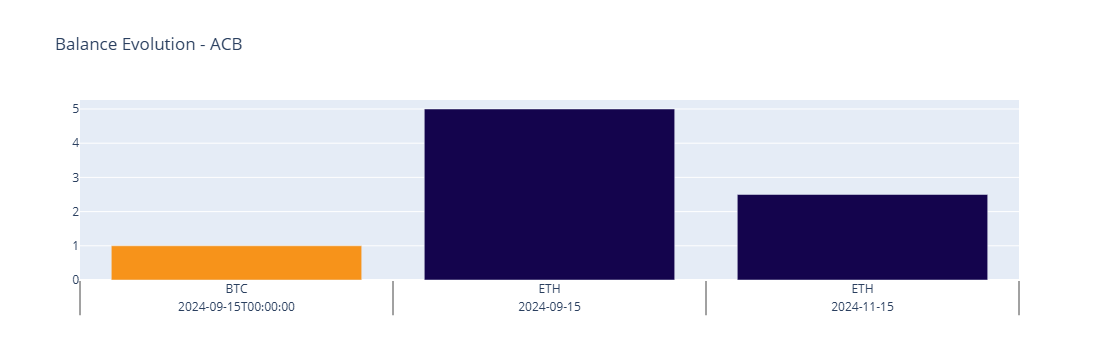

In [178]:
df_balance_evolution['Colors'] = df_balance_evolution['Asset'].map({"BTC":'#f7931a','ETH':'#14044d','ADA':'#2A7ABF'})

# subplot setup
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Bar(x=[df_balance_evolution['Date'], df_balance_evolution['Asset']],
                         y = df_balance_evolution['Units'],
                         marker_color = df_balance_evolution['Colors'],
                         showlegend = False 
                        ), row = 1, col = 1)

fig.update_layout(barmode='stack', title=f"Balance Evolution - {METHOD}")
fig.show()